In [2]:
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import warnings
import tensorflow as tf
import seaborn as sns
import sklearn
import random
import math
import time
import os


from lime.lime_tabular import RecurrentTabularExplainer
from tqdm import tqdm
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.model_selection import GroupKFold
from sklearn import preprocessing
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler , StandardScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation, GRU
from scipy import optimize
from tensorflow.keras import optimizers


from sp_modif.model_function import *
from sp_modif.methods import *
from sp_modif.data_prep import *
from sp_modif.evaluator import *
from sp_modif.SHAP import *
from sp_modif.L2X import *
from methods import *

%matplotlib inline
warnings.filterwarnings('ignore')

SEED = 0
def set_seed(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(SEED)
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

# Appeler la fonction pour fixer le seed
set_seed(SEED)

In [5]:
idx = '2_1'
folder = 'PRONOSTIA/Learning_set/'
bearing = 'Bearing' + idx
base_dir = os.path.join(folder, bearing)

In [144]:

def load_vibration_data(data_folder, idx=None):
    """Charge les fichiers de vibration et calcule le temps en secondes pour chaque échantillon."""
    vibration_files = [f for f in os.listdir(data_folder) if f.startswith('acc_') and f.endswith('.csv')]
    vibration_data = []

    for file in vibration_files:
        file_path = os.path.join(data_folder, file)
        df = pd.read_csv(file_path, names=['Hour', 'Minute', 'Second', 'Microsecond', 'Horizontal_Accel', 'Vertical_Accel'])
        
        # Extraction de l'identifiant du roulement
        bearing_id = file.split('_')[1].split('.')[0]
        df['bearing_id'] = idx + bearing_id
        
        # Calcul du temps en secondes pour chaque échantillon
        df['time_seconds'] = df['Hour'] * 3600 + df['Minute'] * 60 + df['Second'] + df['Microsecond'] * 1e-6
        vibration_data.append(df)

    # Concaténation de toutes les données de vibration en un DataFrame unique
    return pd.concat(vibration_data, ignore_index=True)

def calculate_total_time(vibration_data):
    """Calcule le temps total de l'expérience pour chaque roulement."""
    return vibration_data.groupby('bearing_id')['time_seconds'].max()

def calculate_normalized_rul(vibration_data, total_time):
    """Calcule le RUL normalisé pour chaque échantillon en utilisant la formule RUL_norm = 1 - (RUL_t / T_cycle)."""
    vibration_data['RUL_norm'] = vibration_data.apply(
        lambda row: 1 - (total_time[row['bearing_id']] - row['time_seconds']) / total_time[row['bearing_id']],
        axis=1
    )
    return vibration_data

def main(data_folder, idx):
    """Fonction principale pour charger les données, calculer le temps total et le RUL normalisé."""
    # Charger les données de vibration
    vibration_data = load_vibration_data(data_folder, idx)
    
    # Calculer le temps total de l'expérience pour chaque roulement
    total_time = calculate_total_time(vibration_data)
    
    # Calculer le RUL normalisé
    vibration_data_with_rul = calculate_normalized_rul(vibration_data, total_time)
    
    return vibration_data_with_rul

def plot_signal_pronostia(df, signal_name, unit=None):
    #     train = df
    plt.figure(figsize=(13,5))
    if unit:
        plt.plot('RUL_norm', signal_name,
                data=df[df['Unit']==unit])
    else:
        for i in df['Unit'].unique():
            # if (i % 10 == 0):  # only ploting every 10th unit_nr
            plt.plot('RUL_norm', signal_name, data=df[df['Unit']==i])
            
    plt.xlim(2560, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 2560, 250))
    plt.ylabel(signal_name)
    plt.xlabel('Remaining Use fulLife')
    #plt.savefig(signal_name+'.jpeg')
    plt.show()

In [68]:
# # Utilisation de la fonction principale
# data_folder = base_dir
# vibration_data_with_rul = main(data_folder, idx)
# print(vibration_data_with_rul[['bearing_id', 'time_seconds', 'RUL_norm']].head())

In [134]:
import pandas as pd
import numpy as np
from scipy.stats import kurtosis, skew
from numpy.fft import fft
import os

# Caractéristiques temporelles
def extract_temporal_features(signal):
    """Extrait les caractéristiques temporelles : moyenne, écart type, RMS, skewness, etc."""
    features = {
        'mean': signal.mean(),
        'std': signal.std(),
        'peak_to_peak': signal.max() - signal.min(),
        'rms': np.sqrt(np.mean(signal**2)),
        'mean_abs': np.mean(np.abs(signal)),
        'max_abs': np.max(np.abs(signal)),
        'skewness': skew(signal),
        'kurtosis': kurtosis(signal),
        'form_factor': np.sqrt(np.mean(signal**2)) / np.mean(np.abs(signal)),
        'crest_factor': signal.max() / np.sqrt(np.mean(signal**2)),
        'impulse_factor': signal.max() / np.mean(np.abs(signal)),
        'margin_factor': signal.max() / (np.mean(np.sqrt(np.abs(signal))) ** 2),
        'energy': np.sum(signal**2)  # Ajout explicite de l'énergie
    }
    return features

# Caractéristiques fréquentielles
def extract_frequency_features(signal, sampling_rate=25600):
    """Extrait les caractéristiques fréquentielles."""
    N = len(signal)
    freqs = fft(signal)
    freqs = np.abs(freqs[:N // 2])  # On garde seulement les composantes positives
    freq_bins = np.fft.fftfreq(N, d=1/sampling_rate)[:N // 2]
    
    # Normaliser les fréquences pour calculer l'entropie spectrale
    power_spectrum = freqs**2
    power_spectrum /= np.sum(power_spectrum)  # Normalisation pour que la somme soit égale à 1

    max_amplitude = np.max(freqs)
    energy_band1 = np.sum(freqs[(freq_bins >= 0) & (freq_bins < 500)]**2)
    energy_band2 = np.sum(freqs[(freq_bins >= 500) & (freq_bins < 1000)]**2)
    mean_freq = np.mean(freqs)
    rms_freq = np.sqrt(np.mean(freqs**2))
    spectral_entropy = -np.sum(power_spectrum * np.log2(power_spectrum + 1e-10))  # Entropie spectrale
    
    features = {
        'max_amplitude': max_amplitude,
        'energy_band1': energy_band1,
        'energy_band2': energy_band2,
        'mean_freq': mean_freq,
        'rms_freq': rms_freq,
        'variance_freq': np.var(freqs),
        'std_freq': np.std(freqs),
        'kurtosis_freq': kurtosis(freqs),
        'skewness_freq': skew(freqs),
        'peak_freq': freqs.max(),
        'form_factor_freq': rms_freq / mean_freq,
        'crest_factor_freq': max_amplitude / rms_freq,
        'spectral_entropy': spectral_entropy  # Ajout de l'entropie spectrale
    }
    return features

def extract_all_features(data_folder=None, df = None):
    """Fonction principale pour extraire les 52 caractéristiques (26 pour chaque direction de vibration)."""
    # Charger les données de vibration
    if df is None:
        vibration_data = load_vibration_data(data_folder)
    else:
        vibration_data = df    
    # Initialiser un DataFrame pour stocker toutes les caractéristiques
    features_list = []

    # Extraire les caractéristiques pour chaque roulement
    for bearing_id, group in vibration_data.groupby('bearing_id'):
        temporal_features_h = extract_temporal_features(group['Horizontal_Accel'])
        temporal_features_v = extract_temporal_features(group['Vertical_Accel'])
        frequency_features_h = extract_frequency_features(group['Horizontal_Accel'])
        frequency_features_v = extract_frequency_features(group['Vertical_Accel'])
        
        # Renommer les caractéristiques pour chaque direction
        features = {f"{k}_h": v for k, v in temporal_features_h.items()}
        features.update({f"{k}_v": v for k, v in temporal_features_v.items()})
        features.update({f"{k}_freq_h": v for k, v in frequency_features_h.items()})
        features.update({f"{k}_freq_v": v for k, v in frequency_features_v.items()})
        
        # Ajouter l'identifiant du roulement
        features['bearing_id'] = bearing_id
        
        # Ajouter aux résultats
        features_list.append(features)

    # Convertir la liste de caractéristiques en DataFrame
    features_df = pd.DataFrame(features_list)
    return features_df

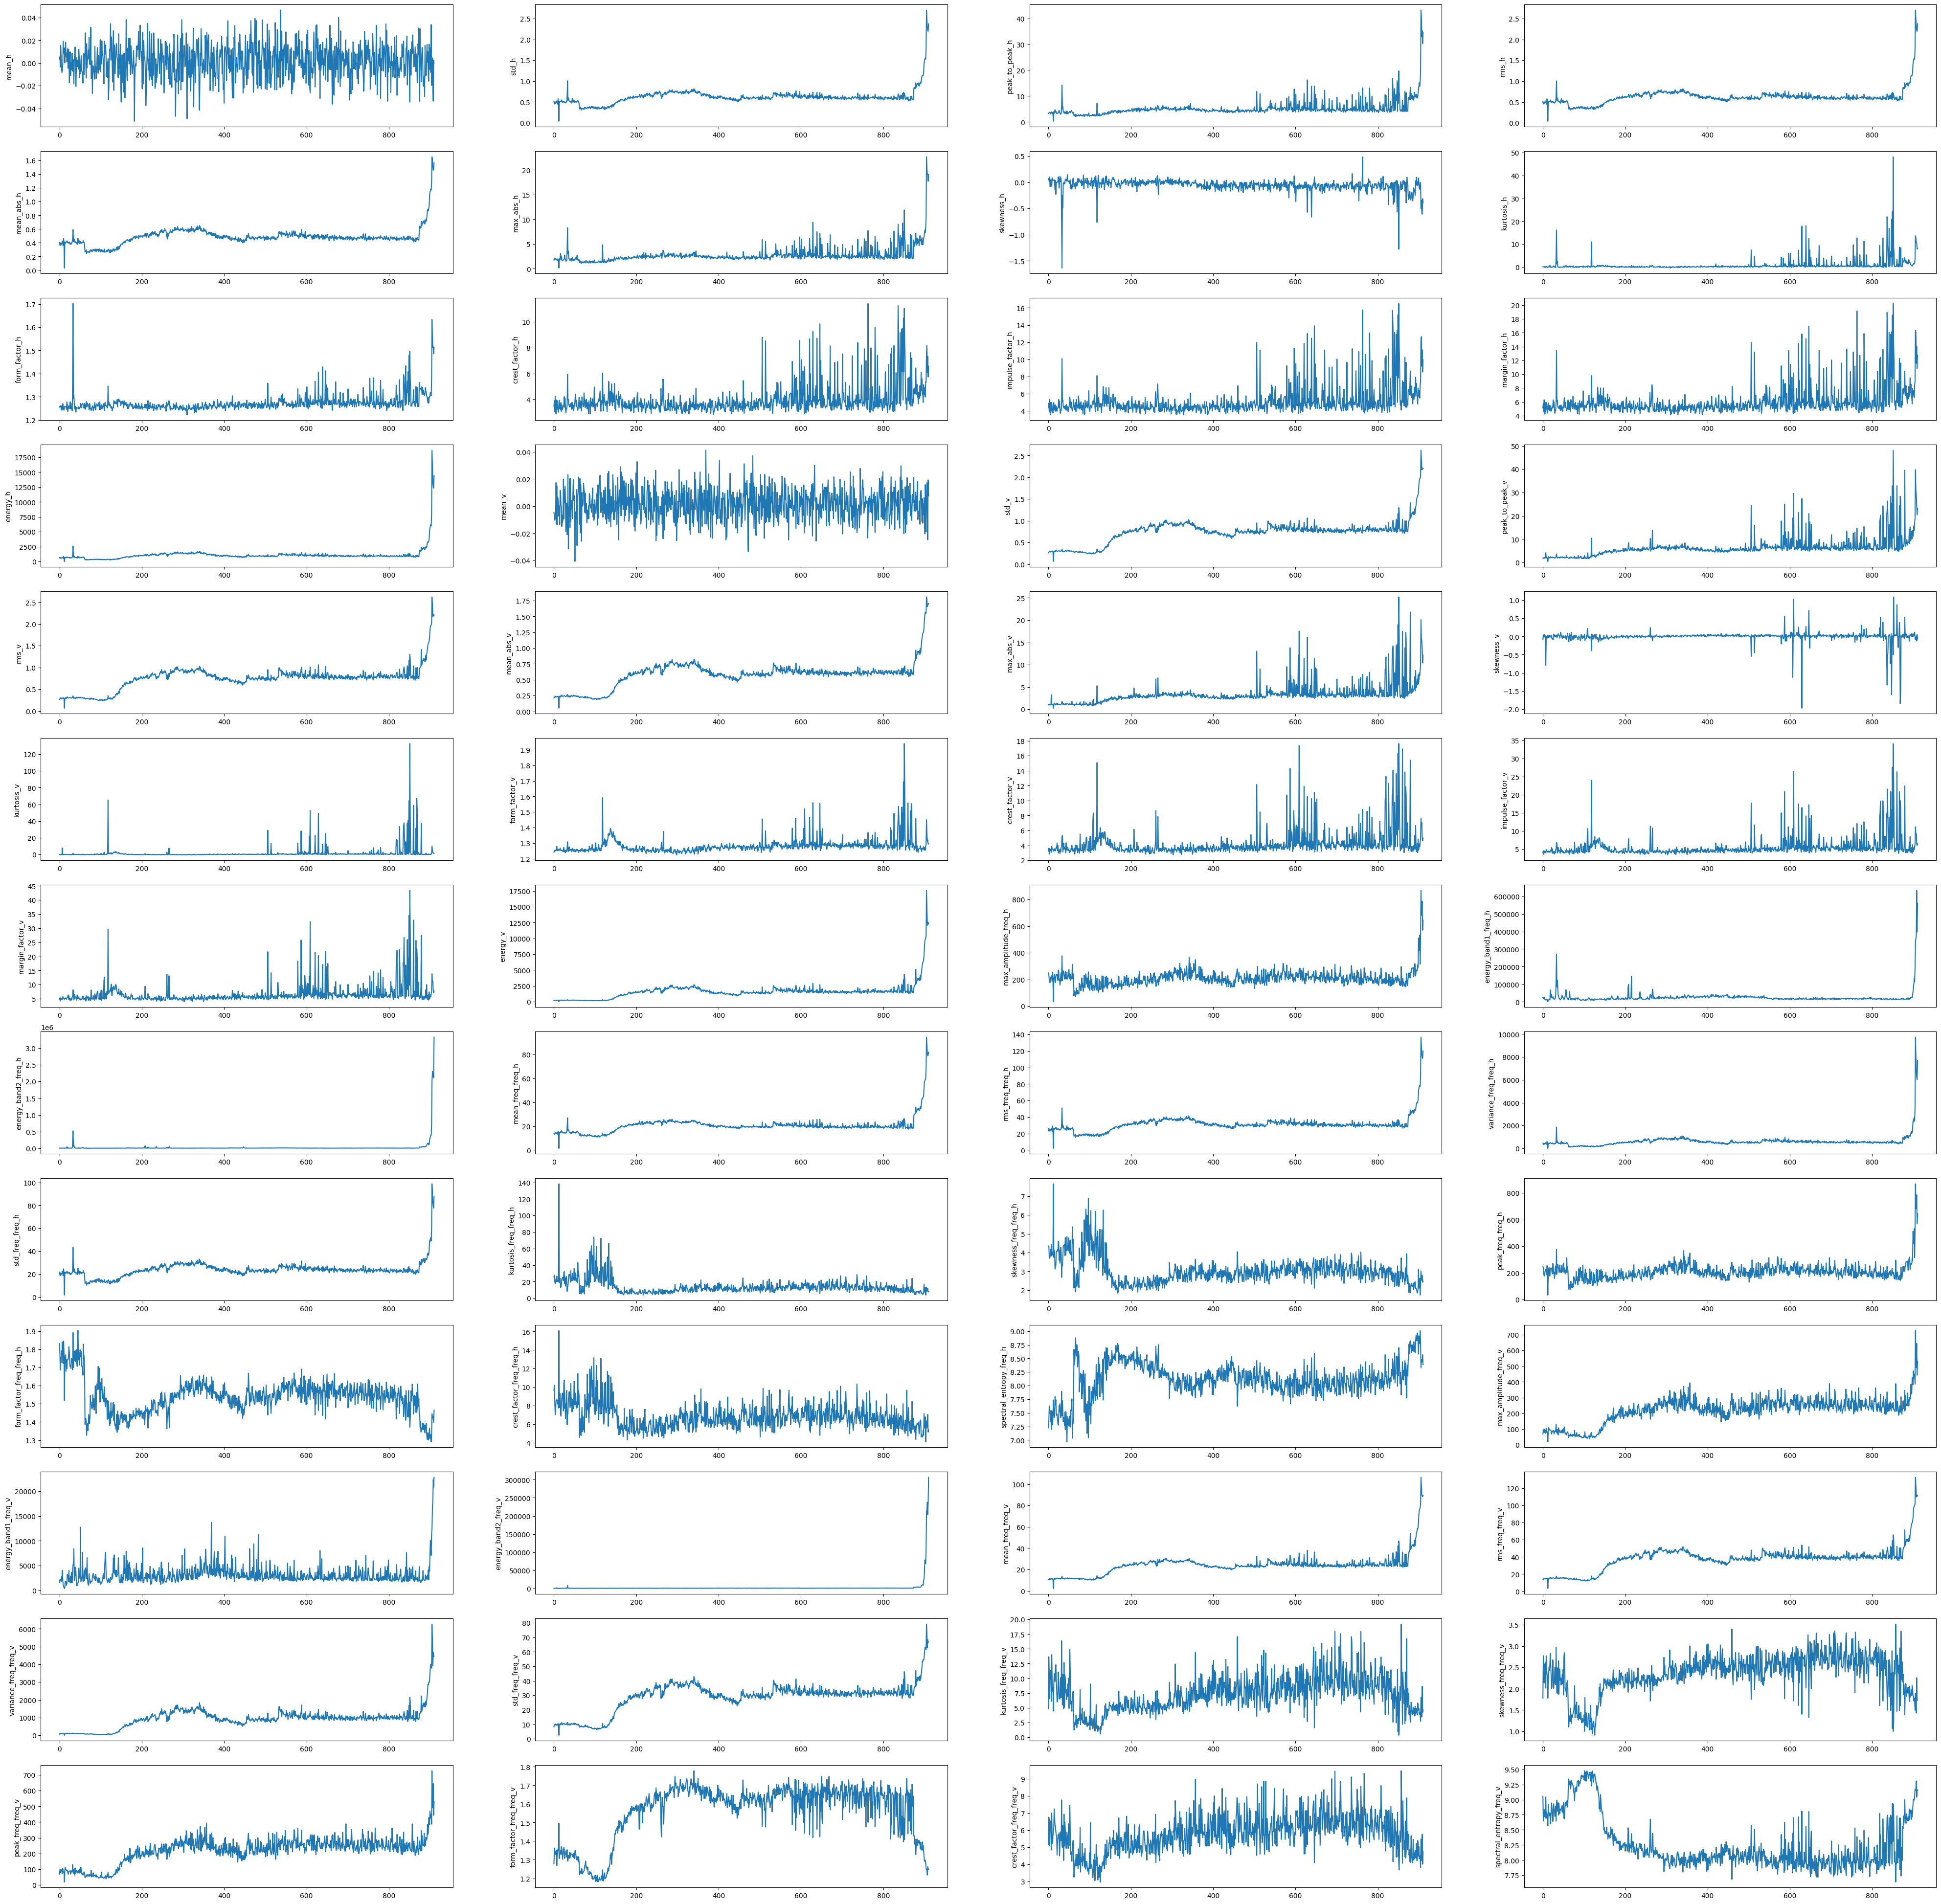

In [143]:
df_all = extract_all_features(df = df)
plt.figure(figsize=(50,50))
i=1
col = df_all.columns
for s in col:
    if s!= 'bearing_id':
        plt.subplot(13, 4, i)
        plt.plot(df_all[s])
        plt.ylabel(s)
    i = i+1
plt.show()